In [1]:
# load libraries
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import geopandas
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Load and prepare data

In [6]:
import os
import pandas as pd
os.chdir('/home/desktop3/itu')
path = os.getcwd()
print(path)

/home/desktop3/itu


In [30]:
# # read in (yaml) configs
with open(path + '/conf/model_config.yaml', 'r') as conf:
    model_config = yaml.safe_load(conf)

# import data
dataset = model_config['model']['loc'] + model_config['model']['file']
dataset = pd.read_csv(dataset)
# subset for faster trial and error
#dataset = dataset.iloc[0:1000,:]

# define predictors and target
predictor   =  model_config['meta']['predictors']
target = model_config['meta']['target']

In [31]:
predictor

['avg_d_kbps',
 'avg_u_kbps',
 'mean_ghm',
 'mean_avg_rad',
 'mean_cf_cvg',
 'change_year_avg_rad',
 'slope_year_avg_rad',
 'change_month_avg_rad',
 'slope_month_avg_rad',
 'estimate_mau',
 'slope_month_cf_cvg',
 'mean_NDVI',
 'slope_year_NDVI',
 'range',
 'population']

In [33]:
target

['target']

In [29]:
dataset['target']

0        1.000000
1        1.000000
2        1.000000
3        1.000000
4        1.000000
           ...   
11727    0.367261
11728    0.617745
11729    0.617745
11730    0.464852
11731    0.761715
Name: target, Length: 11732, dtype: float64

In [27]:
dataset

,source_school_id,latitude,longitude,school_location,geometry,target,mean_ghm,mean_avg_rad,change_year_avg_rad,slope_year_avg_rad,...,slope_year_NDVI,change_month_NDVI,slope_month_NDVI,estimate_dau,estimate_mau,estimate_ready,range,avg_d_kbps,avg_u_kbps,population
0,11000023,-8.7585,-63.8540,POINT (-63.854 -8.7585),"POLYGON ((-63.844 -8.7585, -63.84404815273328 ...",1.000000,0.778150,29.486260,1.040262,0.173377,...,23.184182,352.089866,2.551376,180872,270000,True,1.0,111541.0,41429.0,21621.2770
1,11001364,-8.7627,-63.8642,POINT (-63.8642 -8.762700000000001),"POLYGON ((-63.8542 -8.762700000000001, -63.854...",1.000000,0.813903,32.686109,-0.064534,-0.010756,...,24.580166,336.748641,2.440208,189483,280000,True,1.0,19693.0,16480.0,25260.3300
2,11003138,-8.7579,-63.8554,POINT (-63.8554 -8.757899999999999),POLYGON ((-63.84540000000001 -8.75789999999999...,1.000000,0.781545,29.852872,0.962008,0.160335,...,23.466914,356.627458,2.584257,180714,270000,True,1.0,111541.0,41429.0,32302.7380
3,11003200,-8.7573,-63.8646,POINT (-63.8646 -8.757300000000001),"POLYGON ((-63.8546 -8.757300000000001, -63.854...",1.000000,0.803953,32.056982,0.254048,0.042341,...,25.034986,348.774612,2.527352,188635,280000,True,1.0,26874.0,28402.0,25429.0620
4,11045175,-8.7468,-63.8554,POINT (-63.8554 -8.7468),"POLYGON ((-63.84540000000001 -8.7468, -63.8454...",1.000000,0.748688,27.407618,1.441365,0.240228,...,22.922948,395.943743,2.869158,160030,240000,True,1.0,75285.0,15608.0,33929.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11727,50026666,-23.6691,-54.5632,POINT (-54.5632 -23.6691),"POLYGON ((-54.5532 -23.6691, -54.5532481527332...",0.367261,0.562417,1.335753,0.099359,0.016560,...,-59.898988,172.064010,1.246841,3919,4900,True,1.0,26718.0,14410.0,2835.5640
11728,23197145,-3.8787,-38.6144,POINT (-38.6144 -3.8787),"POLYGON ((-38.60440000000001 -3.8787, -38.6044...",0.617745,0.686202,22.115340,-3.320490,-0.553415,...,35.784600,-413.683806,-2.997709,102043,160000,True,1.0,8270.0,5224.0,63205.2400
11729,23197170,-3.8833,-38.6147,POINT (-38.6147 -3.8833),"POLYGON ((-38.6047 -3.8833, -38.60474815273328...",0.617745,0.675718,20.997906,-3.118815,-0.519803,...,40.873816,-463.981935,-3.362188,101975,160000,True,1.0,4917.0,4271.0,56145.5900
11730,50026852,-22.6533,-53.8636,POINT (-53.8636 -22.6533),"POLYGON ((-53.8536 -22.6533, -53.8536481527332...",0.464852,0.643514,0.567267,0.123326,0.020554,...,-47.845023,775.662016,5.620739,699,1000,True,1.0,5764.0,4058.0,2192.8286


In [20]:
dataset.columns

Index(['source_school_id', 'latitude', 'longitude', 'school_location',
       'geometry', 'target', 'mean_ghm', 'mean_avg_rad', 'change_year_avg_rad',
       'slope_year_avg_rad', 'change_month_avg_rad', 'slope_month_avg_rad',
       'mean_cf_cvg', 'change_year_cf_cvg', 'slope_year_cf_cvg',
       'change_month_cf_cvg', 'slope_month_cf_cvg', 'mean_NDVI',
       'change_year_NDVI', 'slope_year_NDVI', 'change_month_NDVI',
       'slope_month_NDVI', 'estimate_dau', 'estimate_mau', 'estimate_ready',
       'range', 'avg_d_kbps', 'avg_u_kbps', 'population'],
      dtype='object')

In [36]:
# prepare data
X = dataset[predictor]
y = dataset[target]
print('X Shape:', X.shape)
print('y Shape:', y.shape)
   
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = model_config['parameter']['test_size'], 
                                                    random_state = 42, stratify= y)

print('X_train, X_test, y_train, y_test shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("size of training dataset = ", len(X_train))
print("size of test dataset = ", len(X_test))

X Shape: (11732, 15)
y Shape: (11732,)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [6]:
y_train[target].value_counts()

A4A_right
nominal      7942
low           175
dtype: int64

In [7]:
y_test[target].value_counts()

A4A_right
nominal      3404
low            75
dtype: int64

### Prepare model tuning

In [8]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

<ipython-input-8-0d622864b6d4>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


RandomForestClassifier()

In [10]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance on train set
print('Mean ROC AUC: %.3f' % (scores.mean()))

Mean ROC AUC: 0.965


### Model Predictions

In [12]:
y_pred=clf.predict(X_test)

In [13]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9893647599885025


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[  41,   34],
       [   3, 3401]])

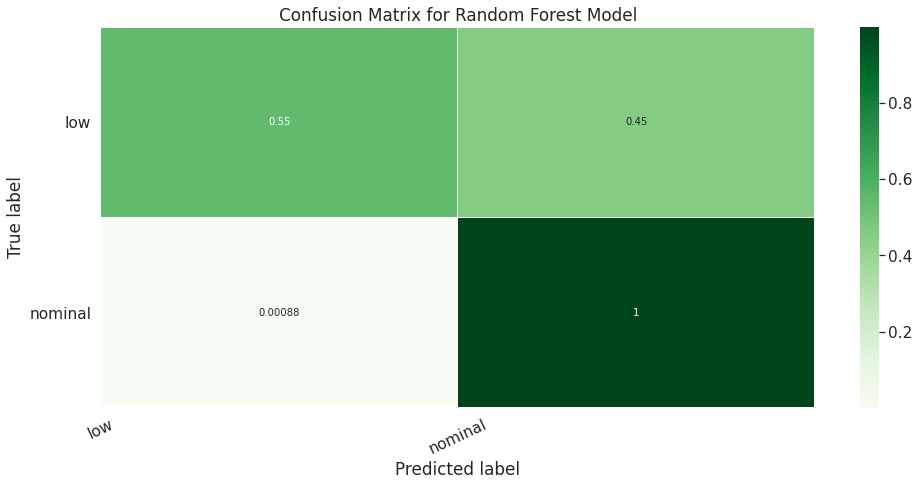

In [15]:
import seaborn as sns

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['low','nominal']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [16]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         low       0.93      0.55      0.69        75
     nominal       0.99      1.00      0.99      3404

    accuracy                           0.99      3479
   macro avg       0.96      0.77      0.84      3479
weighted avg       0.99      0.99      0.99      3479



## Feature Importances

In [17]:
# Make the dataframe
importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": clf.feature_importances_}
).sort_values("Importance")

In [18]:
importance

,Feature,Importance
9,estimate_mau,0.068016
0,avg_d_kbps,0.072820
1,avg_u_kbps,0.073433
5,viirs_slope_yr,0.083547
6,cf_cvg_viirs_slope_yr,0.086458
2,mean_GHM,0.096174
7,viirs_slope_month,0.098656
10,pop_norm,0.100561
3,avg_rad_mean,0.102412
4,cf_cvg_mean,0.104387


<AxesSubplot:title={'center':'Feature Importances'}>

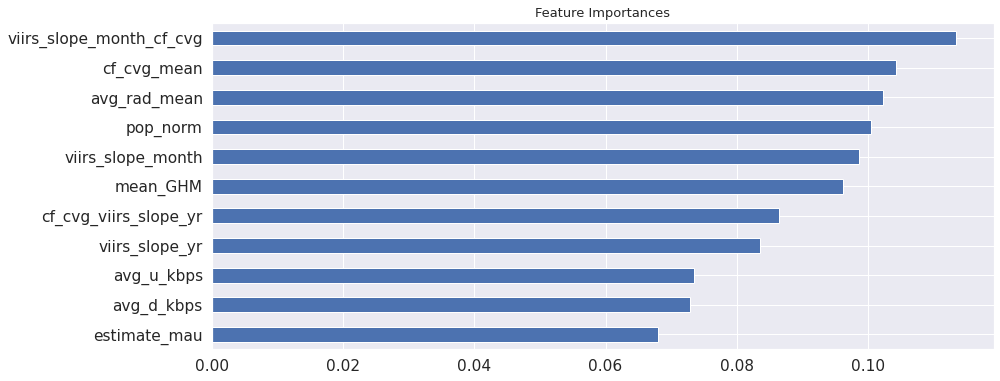

In [19]:
import matplotlib.pyplot as plt
fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Feature Importances', fontdict={'fontsize': '13', 'fontweight' : '3'})

(pd.Series(clf.feature_importances_, index=X.columns)
   .nsmallest(12).plot(kind='barh'))

## Pickling the model for use later on with predictions

In [32]:
#changing the path to save in the models folder
path = '/home/desktop3/itu/models/'
#os.chdir(path)

In [33]:
## pickle the file
# save the model to disk
filename = 'RF_Classifier_Model2.sav'
pickle.dump(clf, open(path + filename, 'wb'))